# Waste Classification Training (Colab Ready)

Notebook này hướng dẫn toàn bộ pipeline: chuẩn bị dữ liệu, huấn luyện mô hình CNN/Transfer Learning, đánh giá và tạo demo Gradio.

## 1. Thiết lập môi trường
- Chạy trên GPU (Runtime → Change runtime type → GPU)
- Kết nối Google Drive nếu dữ liệu/model lưu trên đó.

In [2]:
#@title Mount Google Drive (tùy chọn)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title Cài đặt phụ thuộc
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install -q albumentations==1.4.7 timm==1.0.3 grad-cam==1.5.5 gradio==4.44.0 scikit-learn==1.5.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.7/155.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 70.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 12.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the followin

In [ ]:
#@title Kiem tra tai nguyen Colab
import shutil
import torch

try:
    import psutil
except ImportError:
    psutil = None

print("Tinh trang tai nguyen:")
if torch.cuda.is_available():
    print(f"- GPU: {torch.cuda.get_device_name(0)}")
else:
    print("- GPU: chua bat. Vao Runtime > Change runtime type > GPU.")

total, used, free = shutil.disk_usage("/")
print(f"- O dia: {total/1e9:.1f} GB tong | {free/1e9:.1f} GB trong")

if psutil is not None:
    ram = psutil.virtual_memory()
    print(f"- RAM: {ram.total/1e9:.1f} GB tong | {ram.available/1e9:.1f} GB kha dung")
else:
    print("- RAM: cai psutil de hien thi (pip install psutil)")


## 2. Chuẩn bị dự án
- Nếu đã upload project lên GitHub, clone trực tiếp.
- Nếu làm việc trên Drive, unzip project vào `/content/TrashProject`.

In [11]:
#@title Clone hoặc đồng bộ mã nguồn
import os, shutil, zipfile, sys

PROJECT_PATH = "/content/drive/MyDrive/TrashProject/TrashProject"  # chỉnh sửa nếu cần
GIT_REPO_URL = "https://github.com/tuanng007/TrashProject.git"

if not os.path.exists(PROJECT_PATH):
    !git clone $GIT_REPO_URL $PROJECT_PATH
else:
    print(f"Su dung thu muc co san: {PROJECT_PATH}")

sys.path.append(PROJECT_PATH)
os.chdir(PROJECT_PATH)


Su dung thu muc co san: /content/drive/MyDrive/TrashProject/TrashProject


## 3. Tải và tiền xử lý dữ liệu
- Có thể dùng script sẵn có để tải TrashNet về thư mục data/raw.
- Hoặc dùng dataset công khai khác/Kaggle ở các cell tiếp theo.
- Có thể thay bằng dataset tự thu thập (đưa vào thư mục data/raw).


In [5]:
#@title Tải TrashNet từ GitHub
import os
DOWNLOAD_TRASHNET = True  #@param {type:"boolean"}
DATA_ROOT = "/content/drive/MyDrive/TrashProject/data"  #@param {type:"string"}
RAW_DATA_DIR = f"{DATA_ROOT}/raw"
os.makedirs(RAW_DATA_DIR, exist_ok=True)
if DOWNLOAD_TRASHNET:
    !python scripts/download_trashnet.py --output-dir {RAW_DATA_DIR}
    print("TrashNet downloaded.")
print(f"Raw data folder: {RAW_DATA_DIR}")


python3: can't open file '/content/drive/MyDrive/TrashProject/scripts/download_trashnet.py': [Errno 2] No such file or directory
TrashNet downloaded.
Raw data folder: /content/drive/MyDrive/TrashProject/data/raw


## 3.1 Khám phá dữ liệu tổng quan (EDA trên raw)

- Thống kê phân bố số mẫu theo lớp trên `data/raw` trước khi chia train/val/test.
- Hiển thị một vài ảnh mẫu từ raw để kiểm tra nhanh chất lượng dữ liệu.


So mau theo lop (raw):
  cardboard: 403
  glass: 501
  metal: 410
  paper: 594
  plastic: 482
  trash: 137

Tong so mau: 2527


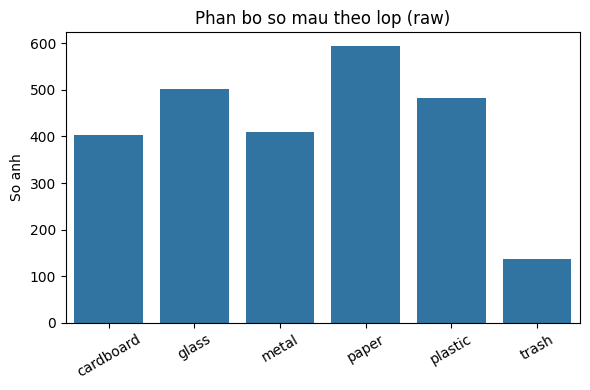

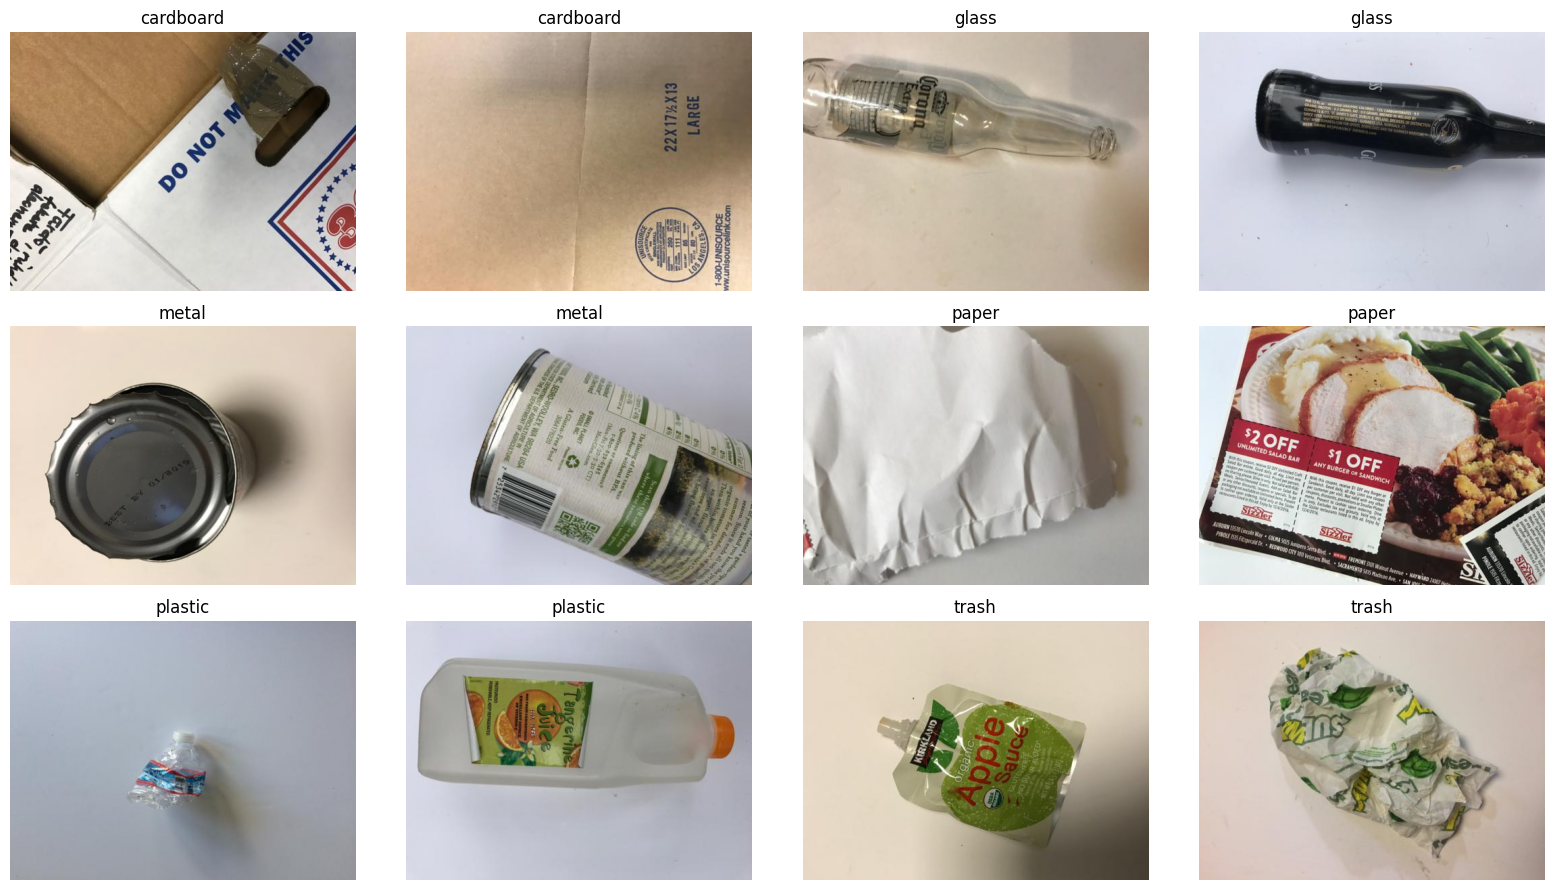

In [7]:
#@title EDA tổng quan trên raw (phân bố lớp)
from pathlib import Path
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

DATA_ROOT = globals().get('DATA_ROOT', '/content/drive/MyDrive/TrashProject/data')
raw_dir = Path(DATA_ROOT) / 'raw'

if not raw_dir.exists():
    print(f'Khong tim thay thu muc raw: {raw_dir}')
else:
    class_counts = {}
    for class_dir in sorted(raw_dir.iterdir()):
        if class_dir.is_dir():
            class_counts[class_dir.name] = len(list(class_dir.glob('*')))

    print('So mau theo lop (raw):')
    for cls, n in class_counts.items():
        print(f'  {cls}: {n}')
    print('\nTong so mau:', sum(class_counts.values()))

    if class_counts:
        plt.figure(figsize=(6, 4))
        sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
        plt.title('Phan bo so mau theo lop (raw)')
        plt.ylabel('So anh')
        plt.xticks(rotation=30)
        plt.tight_layout()
        plt.show()

    # Hien thi mot vai anh mau tu raw
    sample_paths = []
    for cls, n in class_counts.items():
        class_dir = raw_dir / cls
        imgs = list(class_dir.glob('*'))
        if imgs:
            sample_paths.extend(random.sample(imgs, min(2, len(imgs))))

    if sample_paths:
        cols = 4
        rows = (len(sample_paths) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
        axes = axes.flatten()
        for ax, img_path in zip(axes, sample_paths):
            try:
                img = Image.open(img_path).convert('RGB')
                ax.imshow(img)
                ax.set_title(img_path.parent.name)
                ax.axis('off')
            except Exception:
                ax.set_title(f'Loi doc anh: {img_path.name}')
                ax.axis('off')
        for ax in axes[len(sample_paths):]:
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    else:
        print('Khong tim thay anh trong data/raw.')


In [10]:
#@title T?o train/val/test split (70/20/10)
DATA_ROOT = globals().get('DATA_ROOT', '/content/drive/MyDrive/TrashProject/data')
SPLIT_SEED = 42  #@param {type:"integer"}
from pathlib import Path
import random
import shutil

raw_dir = Path(DATA_ROOT) / "raw"
train_dir = Path(DATA_ROOT) / "train"
val_dir = Path(DATA_ROOT) / "val"
test_dir = Path(DATA_ROOT) / "test"

IMAGE_EXTS = {".jpg", ".jpeg", ".png"}
rng = random.Random(SPLIT_SEED)

for folder in [train_dir, val_dir, test_dir]:
    if folder.exists():
        shutil.rmtree(folder)
    folder.mkdir(parents=True, exist_ok=True)

if raw_dir.exists():
    for class_dir in sorted(raw_dir.iterdir()):
        if not class_dir.is_dir():
            continue
        images = [p for p in class_dir.glob('*') if p.suffix.lower() in IMAGE_EXTS]

        if not images:
            continue
        rng.shuffle(images)
        n = len(images)
        n_train = int(0.7 * n)
        n_val = int(0.2 * n)
        splits = {
            train_dir / class_dir.name: images[:n_train],
            val_dir / class_dir.name: images[n_train:n_train + n_val],
            test_dir / class_dir.name: images[n_train + n_val:],
        }
        for split_dir, split_imgs in splits.items():
            split_dir.mkdir(parents=True, exist_ok=True)
            for img_path in split_imgs:
                shutil.copy(img_path, split_dir / img_path.name)
    print("Ho?n th?nh chia t?p d? li?u.")
else:
    print("B? qua b??c chia t?p v? kh?ng t?m th?y data/raw.")


Ho?n th?nh chia t?p d? li?u.


## 3.1 Khám phá dữ liệu (EDA)

- Thống kê phân bố số mẫu theo lớp sau khi chia train/val/test.
- Hiển thị một vài ảnh mẫu để kiểm tra nhanh chất lượng dữ liệu.


Số mẫu theo lớp (train):
  cardboard: 282
  glass: 350
  metal: 287
  paper: 415
  plastic: 337
  trash: 95

Tổng số mẫu train: 1766


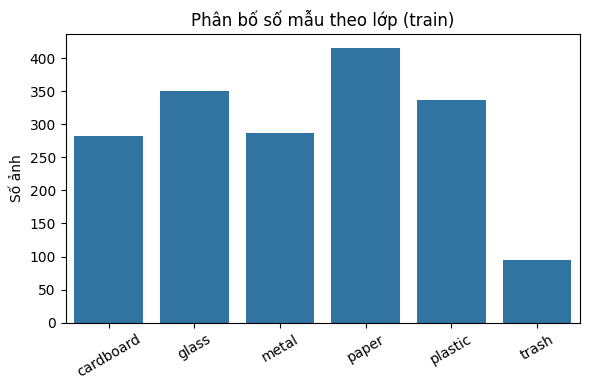

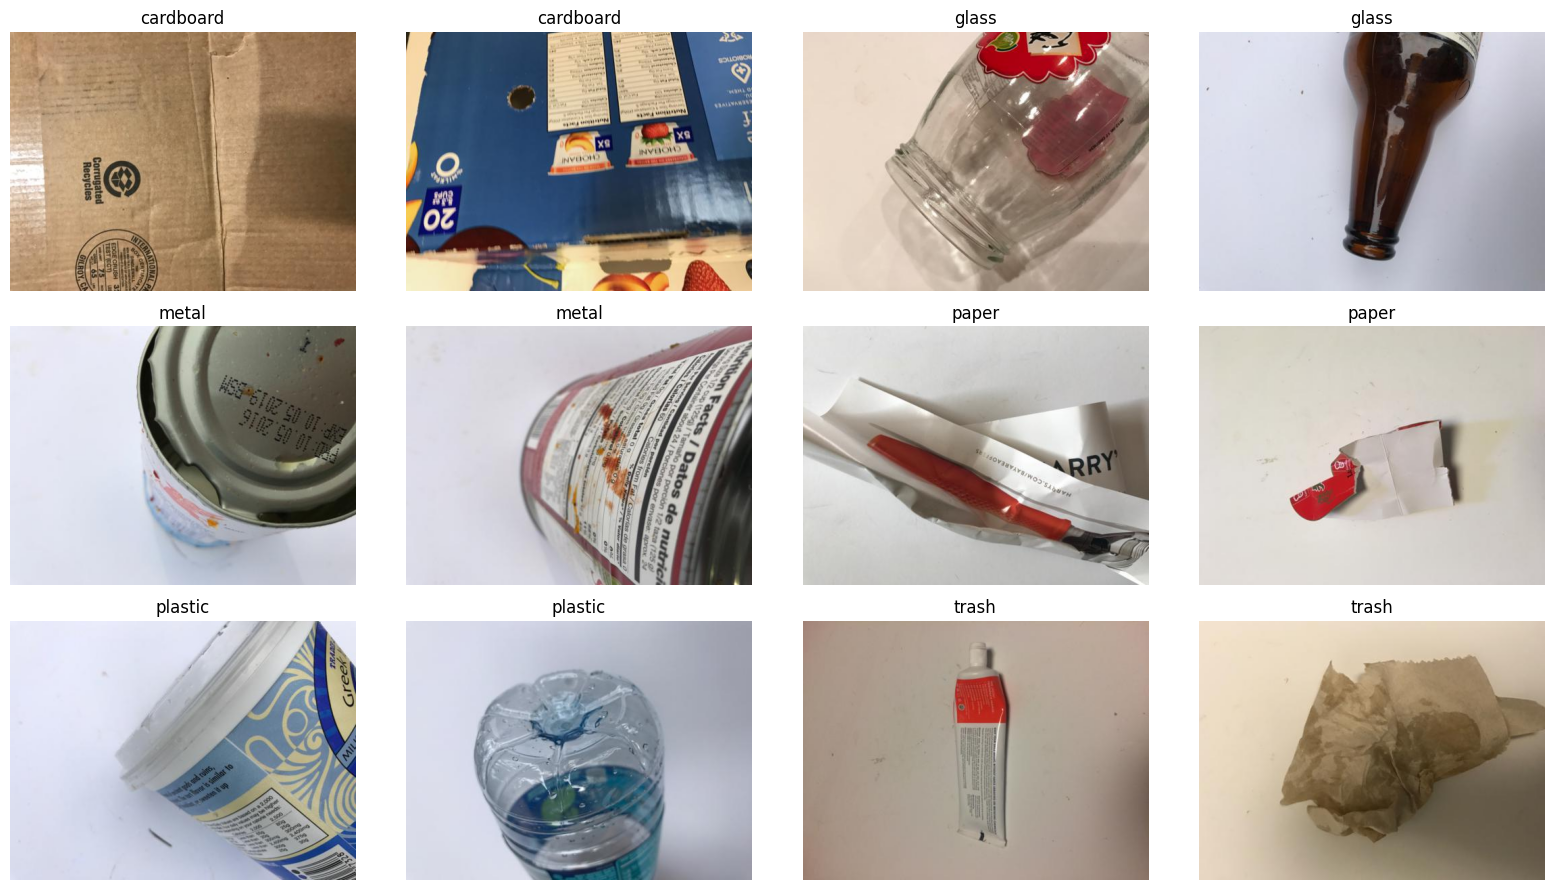

In [8]:
#@title EDA nhanh: phân bố lớp & một vài ảnh mẫu
from pathlib import Path
from collections import Counter
import random
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

DATA_ROOT = globals().get('DATA_ROOT', '/content/drive/MyDrive/TrashProject/data')
train_dir = Path(DATA_ROOT) / 'train'
val_dir = Path(DATA_ROOT) / 'val'
test_dir = Path(DATA_ROOT) / 'test'

def count_images(root: Path):
    counts = {}
    if root.exists():
        for class_dir in sorted(root.iterdir()):
            if class_dir.is_dir():
                counts[class_dir.name] = len(list(class_dir.glob('*')))
    return counts

train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)

print('Số mẫu theo lớp (train):')
for cls, n in train_counts.items():
    print(f'  {cls}: {n}')
print('\nTổng số mẫu train:', sum(train_counts.values()))

plt.figure(figsize=(6,4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title('Phân bố số mẫu theo lớp (train)')
plt.ylabel('Số ảnh')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# Hiển thị một vài ảnh mẫu từ train
sample_paths = []
for cls, n in train_counts.items():
    class_dir = train_dir / cls
    imgs = list(class_dir.glob('*'))
    sample_paths.extend(random.sample(imgs, min(2, len(imgs))))

if sample_paths:
    cols = 4
    rows = (len(sample_paths) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
    axes = axes.flatten()
    for ax, img_path in zip(axes, sample_paths):
        try:
            img = Image.open(img_path).convert('RGB')
            ax.imshow(img)
            ax.set_title(img_path.parent.name)
            ax.axis('off')
        except Exception as exc:  # noqa: BLE001
            ax.set_title(f'Lỗi đọc ảnh: {img_path.name}')
            ax.axis('off')
    for ax in axes[len(sample_paths):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print('Không tìm thấy ảnh trong thư mục train.')


## 4. Cấu hình và huấn luyện
Sử dụng lớp `WasteTrainer` trong `src/training/trainer.py`.

In [15]:
#@title Khoi tao cau hinh huan luyen
from pathlib import Path

AVAILABLE_MODELS = ["resnet18", "mobilenetv3", "efficientnetb0", "vitb16"]

MODEL_LIST = "resnet18, mobilenetv3, efficientnetb0, vitb16"  #@param {type:"string"}
EPOCHS = 50  #@param {type:"integer"}
IMG_SIZE = 224  #@param {type:"integer"}
BATCH_SIZE = 32  #@param {type:"integer"}
NUM_WORKERS = 2  #@param {type:"integer"}
LOSS = "focal"  #@param ["cross_entropy", "focal"]
FOCAL_GAMMA = 2.0  #@param {type:"number"}
USE_BLUR = False  #@param {type:"boolean"}
USE_RANDOM_ERASING = True  #@param {type:"boolean"}
USE_MIXUP = False  #@param {type:"boolean"}
USE_CUTMIX = True  #@param {type:"boolean"}
MIXUP_ALPHA = 0.4  #@param {type:"number"}
CUTMIX_ALPHA = 1.0  #@param {type:"number"}
OPTIM = "adamw"  #@param ["adam", "adamw", "sgd"]
LR = 3e-4  #@param {type:"number"}
WEIGHT_DECAY = 1e-4  #@param {type:"number"}
SCHEDULER = "onecycle"  #@param ["onecycle", "cosine", "step", "none"]
MAX_LR = 1e-3  #@param {type:"number"}
DEVICE = "cuda"  #@param ["cuda", "cpu"]
LOG_EVERY = 20  #@param {type:"integer"}
FREEZE_BACKBONE_EPOCHS = 5  #@param {type:"integer"}
OUTPUT_DIR = "/content/drive/MyDrive/TrashProject/artifacts"  #@param {type:"string"}
EARLY_STOP_PATIENCE = 3  #@param {type:"integer"}
EARLY_STOP_MIN_DELTA = 0.002  #@param {type:"number"}
SELECT_MODEL_METRIC = "macro_f1"  #@param ["macro_f1", "accuracy", "macro_precision", "macro_recall"]

MODEL_NAMES = [name.strip().lower() for name in MODEL_LIST.split(",") if name.strip()]
MODEL_NAMES = [name for name in MODEL_NAMES if name in AVAILABLE_MODELS]
if not MODEL_NAMES:
    MODEL_NAMES = ["resnet18"]
    print("MODEL_LIST khong hop le, su dung mac dinh resnet18.")

from src.training.dataset import DataConfig
from src.training.losses import LossConfig
from src.training.optim import OptimConfig, SchedulerConfig
from src.training.trainer import TrainConfig, WasteTrainer

DATA_ROOT = globals().get('DATA_ROOT', '/content/drive/MyDrive/TrashProject/data')
data_cfg = DataConfig(
    train_dir=Path(DATA_ROOT) / "train",
    val_dir=Path(DATA_ROOT) / "val",
    test_dir=Path(DATA_ROOT) / "test",
    img_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    use_blur=USE_BLUR,
    use_random_erasing=USE_RANDOM_ERASING,
)

loss_cfg = LossConfig(name=LOSS, gamma=FOCAL_GAMMA) if LOSS == "focal" else LossConfig(name=LOSS)
optim_cfg = OptimConfig(name=OPTIM, lr=LR, weight_decay=WEIGHT_DECAY)
scheduler_cfg = None
if SCHEDULER != "none":
    scheduler_cfg = SchedulerConfig(name=SCHEDULER, max_lr=MAX_LR)

BASE_OUTPUT_DIR = Path(OUTPUT_DIR)
BASE_OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

BASE_TRAIN_KWARGS = dict(
    data=data_cfg,
    loss=loss_cfg,
    optim=optim_cfg,
    scheduler=scheduler_cfg,
    epochs=EPOCHS,
    device=DEVICE,
    log_every=LOG_EVERY,
    freeze_backbone_epochs=FREEZE_BACKBONE_EPOCHS,
    use_mixup=USE_MIXUP,
    use_cutmix=USE_CUTMIX,
    mixup_alpha=MIXUP_ALPHA,
    cutmix_alpha=CUTMIX_ALPHA,
    early_stop_patience=EARLY_STOP_PATIENCE,
    early_stop_min_delta=EARLY_STOP_MIN_DELTA,
)

print(f"Models: {MODEL_NAMES}")
print(f"Epochs: {EPOCHS}, Batch size: {BATCH_SIZE}, LR: {LR}")
print(f"Loss: {LOSS}, Scheduler: {SCHEDULER}, Freeze epochs: {FREEZE_BACKBONE_EPOCHS}")
print(f"Artifacts root: {BASE_OUTPUT_DIR}")


Models: ['resnet18', 'mobilenetv3', 'efficientnetb0', 'vitb16']
Epochs: 50, Batch size: 32, LR: 0.0003
Loss: focal, Scheduler: onecycle, Freeze epochs: 5
Artifacts root: /content/drive/MyDrive/TrashProject/artifacts


### 4.1 Minh hoạ ảnh sau resize & augmentation

- Cell dưới đây giúp trực quan hoá ảnh gốc, ảnh sau resize/crop và các phiên bản sau data augmentation.
- Dùng trực tiếp pipeline trong `src/training/dataset.py` để đảm bảo giống hệt khi huấn luyện.


In [ ]:
#@title Vi du minh hoa augmentation (train transforms, blur, erasing, mixup, cutmix)
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from src.training.dataset import WasteDataset, default_transforms

DATA_ROOT = globals().get('DATA_ROOT', '/content/TrashProject/data')
IMG_SIZE = globals().get('IMG_SIZE', 224)

# Lay transforms giong training (co tinh den blur, random erasing)
USE_BLUR = globals().get('USE_BLUR', False)
USE_RANDOM_ERASING = globals().get('USE_RANDOM_ERASING', False)
train_tf, eval_tf, _ = default_transforms(
    IMG_SIZE,
    use_blur=USE_BLUR,
    use_random_erasing=USE_RANDOM_ERASING,
)
raw_ds = WasteDataset(Path(DATA_ROOT) / 'train', transform=None)

# Lay mot anh goc
pil_img, _ = raw_ds[0]

# Hien thi anh goc vs sau resize/crop (eval transform)
eval_tensor = eval_tf(pil_img)
mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
eval_vis = (eval_tensor * std + mean).clamp(0, 1)

fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(pil_img)
axes[0].set_title('Anh goc (raw)')
axes[0].axis('off')
axes[1].imshow(eval_vis.permute(1, 2, 0).cpu().numpy())
axes[1].set_title('Sau resize/crop (eval_tf)')
axes[1].axis('off')
plt.tight_layout()
plt.show()

# Tao nhieu phien ban augmentation tu cung mot anh (train_tf)
imgs = []
for _ in range(6):
    t = train_tf(pil_img)
    t = (t * std + mean).clamp(0, 1)
    imgs.append(t)

grid = make_grid(torch.stack(imgs), nrow=6)
plt.figure(figsize=(12, 3))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.axis('off')
plt.title('Cung mot anh sau cac lan augmentation khac nhau (train transforms)')
plt.show()

# Minh hoa mixup / cutmix tren batch nho (neu dang bat trong config)
USE_MIXUP = globals().get('USE_MIXUP', False)
USE_CUTMIX = globals().get('USE_CUTMIX', False)
if USE_MIXUP or USE_CUTMIX:
    # Tao batch 4 anh da duoc train_tf (co blur / erasing neu bat)
    batch_imgs = []
    for _ in range(4):
        t = train_tf(pil_img)
        batch_imgs.append(t)
    batch = torch.stack(batch_imgs)

    mixed_list = []
    if USE_MIXUP:
        alpha = float(globals().get('MIXUP_ALPHA', 0.4))
        lam = np.random.beta(alpha, alpha)
        idx = torch.randperm(batch.size(0))
        mixed = lam * batch + (1 - lam) * batch[idx]
        mixed_list.append(mixed)

    if USE_CUTMIX:
        alpha = float(globals().get('CUTMIX_ALPHA', 1.0))
        lam = np.random.beta(alpha, alpha)
        b, c, h, w = batch.size()
        cx = np.random.randint(w)
        cy = np.random.randint(h)
        cut_w = int(w * (1 - lam) ** 0.5)
        cut_h = int(h * (1 - lam) ** 0.5)
        x0 = max(cx - cut_w // 2, 0)
        y0 = max(cy - cut_h // 2, 0)
        x1 = min(cx + cut_w // 2, w)
        y1 = min(cy + cut_h // 2, h)
        idx = torch.randperm(b)
        cut = batch.clone()
        cut[:, :, y0:y1, x0:x1] = batch[idx, :, y0:y1, x0:x1]
        mixed_list.append(cut)

    if mixed_list:
        vis = []
        for img_t in mixed_list[0]:
            img_vis = (img_t * std + mean).clamp(0, 1)
            vis.append(img_vis)
        grid2 = make_grid(torch.stack(vis), nrow=len(vis))
        plt.figure(figsize=(8, 3))
        plt.imshow(grid2.permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
        if USE_MIXUP and USE_CUTMIX:
            title = 'Batch sau mixup + cutmix'
        elif USE_MIXUP:
            title = 'Batch sau mixup'
        else:
            title = 'Batch sau cutmix'
        plt.title(title)
        plt.show()


In [ ]:
#@title Huan luyen va so sanh mo hinh
from pathlib import Path

try:
    import pandas as pd
except ImportError as exc:
    raise RuntimeError('Can install pandas trong moi truong notebook') from exc

trained_models = {}
results = []

for model_name in MODEL_NAMES:
    print(f"===== Huan luyen {model_name} =====")
    cfg = TrainConfig(
        model_name=model_name,
        output_dir=BASE_OUTPUT_DIR / model_name,
        **BASE_TRAIN_KWARGS,
    )
    trainer = WasteTrainer(cfg)
    report, cm = trainer.train()
    trained_models[model_name] = {"trainer": trainer, "report": report, "cm": cm}
    if report:
        macro = report.get("macro avg", {})
        results.append({
            "model": model_name,
            "test_accuracy": report.get("accuracy"),
            "macro_precision": macro.get("precision"),
            "macro_recall": macro.get("recall"),
            "macro_f1": macro.get("f1-score"),
        })
    else:
        results.append({
            "model": model_name,
            "test_accuracy": None,
            "macro_precision": None,
            "macro_recall": None,
            "macro_f1": None,
        })
    print()

MODEL_RESULTS_DF = None
best_trainer = None
best_report = None
best_cm = None
best_model_name = None

if results:
    MODEL_RESULTS_DF = pd.DataFrame(results).set_index("model")
    display(MODEL_RESULTS_DF)

    metric_series = MODEL_RESULTS_DF[SELECT_MODEL_METRIC]
    if metric_series.notna().any():
        best_model_name = metric_series.astype(float).idxmax()
    else:
        best_model_name = MODEL_NAMES[0]
        print("Khong co chi so hop le tren test, chon mo hinh dau tien.")
    print(f"Chon mo hinh tot nhat: {best_model_name} (theo {SELECT_MODEL_METRIC})")
    best_info = trained_models[best_model_name]
    best_trainer = best_info["trainer"]
    best_report = best_info["report"]
    best_cm = best_info["cm"]
else:
    print("Khong co ket qua nao. Hay kiem tra data/raw.")


### 4.2 Biểu đồ huấn luyện (loss & accuracy)

- Cell dưới đây vẽ lại loss/accuracy theo epoch từ file `history.pth` của mô hình đã huấn luyện.
- Có thể chọn tên mô hình trùng với `MODEL_LIST`/`MODEL_NAMES` (ví dụ: `resnet18`, `mobilenetv3`, `efficientnetb0`, `vitb16`).


In [ ]:
#@title Bieu do loss & accuracy theo epoch
from pathlib import Path
import torch
import matplotlib.pyplot as plt

PLOT_MODEL = "efficientnetb0"  #@param {type:"string"}

BASE_OUTPUT_DIR = globals().get('BASE_OUTPUT_DIR', Path('artifacts'))
exp_dir = BASE_OUTPUT_DIR / PLOT_MODEL
history_path = exp_dir / 'history.pth'

print(f"Doc history tu: {history_path}")
if not history_path.exists():
    print("Khong tim thay history.pth. Hay chac chan da train va OUTPUT_DIR dung.")
else:
    history = torch.load(history_path)
    if not isinstance(history, dict) or 'train_loss' not in history:
        print("Dinh dang history khong hop le.")
    else:
        epochs = range(1, len(history['train_loss']) + 1)

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], label='Train loss')
        plt.plot(epochs, history['val_loss'], label='Val loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'Loss - {PLOT_MODEL}')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['val_acc'], label='Val accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title(f'Val accuracy - {PLOT_MODEL}')
        plt.legend()

        plt.tight_layout()
        plt.show()


In [ ]:
#@title Bao cao chi tiet mo hinh tot nhat
try:
    import pandas as pd
except ImportError as exc:
    raise RuntimeError('Can install pandas trong moi truong notebook') from exc

if 'best_report' in globals() and best_report:
    report_df = pd.DataFrame(best_report).T
    display(report_df)
else:
    print("Chua co ket qua nao. Hay chay cell huan luyen truoc.")


In [ ]:
#@title Hien thi ma tran nham lan
import matplotlib.pyplot as plt
import seaborn as sns
import torch

if 'best_cm' in globals() and best_cm is not None:
    cm_obj = best_cm
    cm_np = cm_obj.numpy() if isinstance(cm_obj, torch.Tensor) else cm_obj
    labels = list(best_trainer.idx_to_class.values()) if 'best_trainer' in globals() and best_trainer else []
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_np, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
else:
    print('Chua co ma tran nham lan. Hay chay cell huan luyen truoc.')


In [ ]:
#@title Phan tich loi: hien thi mot so mau du doan sai
import random
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch

if 'best_trainer' not in globals() or best_trainer is None:
    print('Chua co mo hinh tot nhat. Hay chay cell huan luyen truoc.')
else:
    device = best_trainer.device
    model = best_trainer.model.eval()
    loader = best_trainer.test_loader or best_trainer.val_loader
    if loader is None:
        print('Khong co test/val loader de phan tich.')
    else:
        dataset = loader.dataset
        wrong_samples = []
        with torch.no_grad():
            for idx in range(len(dataset)):
                img_tensor, label = dataset[idx]
                logits = model(img_tensor.unsqueeze(0).to(device))
                pred = int(torch.argmax(logits, dim=1).item())
                if pred != int(label):
                    img_path, _ = dataset.samples[idx]
                    wrong_samples.append((img_path, int(label), pred))

        if not wrong_samples:
            print('Khong tim thay mau du doan sai tren loader nay.')
        else:
            n_show = min(8, len(wrong_samples))
            samples_to_show = random.sample(wrong_samples, n_show)
            cols = 4
            rows = (n_show + cols - 1) // cols
            fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
            axes = axes.flatten()
            for ax, (img_path, label, pred) in zip(axes, samples_to_show):
                try:
                    img = Image.open(img_path).convert('RGB')
                    ax.imshow(img)
                    true_name = best_trainer.idx_to_class[label]
                    pred_name = best_trainer.idx_to_class[pred]
                    ax.set_title(f'T:{true_name} / P:{pred_name}')
                    ax.axis('off')
                except Exception as exc:  # noqa: BLE001
                    ax.set_title(f'Loi doc anh: {Path(img_path).name}')
                    ax.axis('off')
            for ax in axes[n_show:]:
                ax.axis('off')
            plt.tight_layout()
            plt.show()


## 5. Demo Gradio
Tải trọng số tốt nhất và tạo UI đơn giản cho phép người dùng upload ảnh.

In [16]:
#@title Khoi tao Gradio demo (chon model + icon + top 6)
import gradio as gr
import gradio_client.utils as gradio_utils

# Work around Gradio bug when additionalProperties=False produces a bool schema
_original_json_schema_to_python_type = gradio_utils._json_schema_to_python_type

def _safe_json_schema_to_python_type(schema, defs):
    if isinstance(schema, bool):
        return 'Any'
    return _original_json_schema_to_python_type(schema, defs)

gradio_utils._json_schema_to_python_type = _safe_json_schema_to_python_type

from pathlib import Path
from PIL import Image
import torch

from src.training.dataset import WasteDataset, default_transforms
from src.training.trainer import build_model

CLASS_ICONS = {
    'cardboard': '\U0001F4E6',  # icon cardboard
    'glass': '\U0001F37E',      # icon glass bottle
    'metal': '\U0001F96B',      # icon metal can
    'paper': '\U0001F4C4',      # icon paper
    'plastic': '\U0001F9F4',    # icon plastic bottle
    'trash': '\U0001F5D1',      # icon trash bin
}

def _infer_class_to_idx_from_data_root():
    data_root = globals().get('DATA_ROOT')
    if not data_root:
        return None
    train_dir = Path(data_root) / 'train'
    if not train_dir.exists():
        return None
    return WasteDataset(train_dir).class_to_idx


def _load_checkpoint(model_key: str, ckpt_path: Path):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    state = torch.load(ckpt_path, map_location=device)

    class_to_idx = state.get('class_to_idx') if isinstance(state, dict) else None
    if not class_to_idx:
        class_to_idx = _infer_class_to_idx_from_data_root()
    if not class_to_idx:
        raise RuntimeError(
            "Khong tim thay 'class_to_idx' trong checkpoint va cung khong suy ra duoc tu DATA_ROOT/train. "
            "Hay chay train lai de tao checkpoint moi (co metadata), hoac set DATA_ROOT dung."
        )

    idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}
    num_classes = len(idx_to_class)

    model_name = model_key
    if isinstance(state, dict) and state.get('model_name'):
        model_name = state['model_name']

    img_size = int(globals().get('IMG_SIZE', 224))
    if isinstance(state, dict) and state.get('img_size'):
        img_size = int(state['img_size'])

    model = build_model(str(model_name), num_classes)
    if isinstance(state, dict) and 'model_state' in state:
        model.load_state_dict(state['model_state'])
    else:
        model.load_state_dict(state)
    model.to(device)
    model.eval()

    _, eval_tf, _ = default_transforms(img_size)
    class_names = [idx_to_class[idx] for idx in sorted(idx_to_class)]
    return {'model': model, 'device': device, 'class_names': class_names, 'eval_tf': eval_tf}


# Load models: prefer trained_models (neu vua train xong trong cung session); fallback load tu artifacts tren Drive
loaded_models = {}

if 'trained_models' in globals() and trained_models:
    model_names = sorted(trained_models.keys())
    for name in model_names:
        ckpt_path = trained_models[name]['trainer'].config.output_dir / 'best.pt'
        loaded_models[name] = _load_checkpoint(name, ckpt_path)
else:
    base_output_dir = globals().get('BASE_OUTPUT_DIR')
    if base_output_dir is None:
        base_output_dir = Path(globals().get('OUTPUT_DIR', 'artifacts'))
    else:
        base_output_dir = Path(base_output_dir)

    model_names = list(globals().get('MODEL_NAMES') or [])
    if not model_names and base_output_dir.exists():
        # infer tu subfolders: artifacts/<model_name>/best.pt
        model_names = sorted([p.name for p in base_output_dir.iterdir() if p.is_dir()])

    if not model_names and (base_output_dir / 'best.pt').exists():
        # Truong hop output_dir=artifacts va luu best.pt ngay trong root
        loaded_models['model'] = _load_checkpoint('resnet18', base_output_dir / 'best.pt')
        model_names = ['model']
    else:
        for name in model_names:
            ckpt_path = base_output_dir / name / 'best.pt'
            if not ckpt_path.exists():
                raise FileNotFoundError(f'Khong tim thay checkpoint: {ckpt_path}')
            loaded_models[name] = _load_checkpoint(name, ckpt_path)

    model_names = list(loaded_models.keys())

if not model_names:
    raise RuntimeError(
        'Khong co model nao de demo. Hay set OUTPUT_DIR/BASE_OUTPUT_DIR dung toi thu muc chua best.pt tren Drive.'
    )


def predict(image: Image.Image, model_name: str):
    if image is None:
        return {}
    info = loaded_models[model_name]
    model = info['model']
    device = info['device']
    class_names = info['class_names']
    tensor = info['eval_tf'](image).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(tensor)
        probs = torch.softmax(logits, dim=1)[0].detach().cpu().numpy()

    scores = {}
    for i, name in enumerate(class_names):
        icon = CLASS_ICONS.get(name, '')
        label = f"{icon} {name}" if icon else name
        scores[label] = float(probs[i])
    return scores


demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type='pil', label='Upload anh rac'),
        gr.Dropdown(choices=model_names, value=model_names[0], label='Chon mo hinh'),
    ],
    outputs=gr.Label(num_top_classes=6, label='Du doan loai rac (top 6)'),
    title='Phan loai rac - So sanh mo hinh',
    description=(
        'Upload anh rac (chai nhua, giay, kim loai, thuy tinh, cardboard, trash...) '
        'de chon va so sanh cac mo hinh (ResNet18, MobileNetV3, EfficientNetB0, ViT...) tren cung mot anh.'
    ),
)


demo.launch(share=True)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 130MB/s]


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 92.4MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 130MB/s] 


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:03<00:00, 99.9MB/s]
/usr/local/lib/python3.12/dist-packages/gradio/analytics.py:106: UserWarning: IMPORTANT: You are using gradio version 4.44.0, however version 4.44.1 is available, please upgrade. 
--------
  warnings.warn(
ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __c

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://2b3949bf6ca8f85dde.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


ERROR:    Exception in ASGI application
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/protocols/http/h11_impl.py", line 403, in run_asgi
    result = await app(  # type: ignore[func-returns-value]
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/uvicorn/middleware/proxy_headers.py", line 60, in __call__
    return await self.app(scope, receive, send)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/fastapi/applications.py", line 1139, in __call__
    await super().__call__(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/applications.py", line 107, in __call__
    await self.middleware_stack(scope, receive, send)
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py", line 186, in __call__
    raise exc
  File "/usr/local/lib/python3.12/dist-packages/starlette/middleware/errors.py",

KeyboardInterrupt: 

## 6. Lưu kết quả và tải xuống
- Lưu lại mô hình, báo cáo metrics vào Drive.
- Đảm bảo cập nhật báo cáo đồ án với bảng kết quả và nhận xét.

## 7. So sánh mô hình
Sau khi chạy huấn luyện với các kiến trúc khác nhau, hãy đặt `OUTPUT_DIR` khác nhau cho mỗi lần (ví dụ `artifacts_resnet18`, `artifacts_mobilenet`).
Cell dưới đây sẽ đọc các thư mục output đó, tổng hợp Accuracy/Macro F1 trên test và best val acc để bạn so sánh nhanh.
Chỉnh sửa biến `EXPERIMENT_DIRS` theo danh sách mô hình bạn đã huấn luyện.


In [ ]:
#@title Tổng hợp kết quả các mô hình đã huấn luyện
from pathlib import Path
import torch

EXPERIMENT_DIRS = {
    "resnet18": "/content/TrashProject/artifacts/resnet18",
    "mobilenetv3": "/content/TrashProject/artifacts/mobilenetv3",
    "efficientnetb0": "/content/TrashProject/artifacts/efficientnetb0",
    "vit16": "/content/TrashProject/artifacts/vit16"
}  # Chỉnh sửa theo các output_dir bạn đã dùng

summary = []
for name, dir_path in EXPERIMENT_DIRS.items():
    dir_path = Path(dir_path)
    if not dir_path.exists():
        print(f"[WARN] {dir_path} không tồn tại, bỏ qua.")
        continue
    report_path = dir_path / "classification_report.pth"
    history_path = dir_path / "history.pth"
    macro_f1 = accuracy = best_val_acc = None

    if report_path.exists():
        report = torch.load(report_path)
        macro_f1 = report.get("macro avg", {}).get("f1-score")
        accuracy = report.get("accuracy")
    if history_path.exists():
        history = torch.load(history_path)
        if isinstance(history, dict) and "val_acc" in history:
            best_val_acc = max(history["val_acc"])

    summary.append({
        "model": name,
        "output_dir": str(dir_path),
        "test_accuracy": accuracy,
        "test_macro_f1": macro_f1,
        "best_val_acc": best_val_acc,
    })

if not summary:
    print("Chưa có kết quả nào. Hãy chạy huấn luyện và lưu output_dir riêng cho từng mô hình.")
else:
    header = ("Model", "Output Dir", "Test Acc", "Test Macro F1", "Best Val Acc")
    row_fmt = "{:<15} {:<40} {:>11} {:>15} {:>13}"
    print(row_fmt.format(*header))
    print('-' * 96)
    for row in summary:
        print(row_fmt.format(
            row["model"],
            row["output_dir"],
            f"{row['test_accuracy']:.3f}" if row["test_accuracy"] is not None else "n/a",
            f"{row['test_macro_f1']:.3f}" if row["test_macro_f1"] is not None else "n/a",
            f"{row['best_val_acc']:.3f}" if row["best_val_acc"] is not None else "n/a",
        ))
